##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# 3D 컨볼루션을 사용한 비디오 동화 작업


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tweening_conv3d"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/hub/tutorials/tweening_conv3d.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/hub/tutorials/tweening_conv3d.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/hub/tutorials/tweening_conv3d.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Download notebook</a>
  </td>
  <td><a href="https://tfhub.dev/google/tweening_conv3d_bair/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF Hub 모델보기</a></td>
</table>

Yunpeng Li, Dominik Roblek, and Marco Tagliasacchi. From Here to There: Video Inbetweening Using Direct 3D Convolutions, 2019.

https://arxiv.org/abs/1905.10240

현재 Hub의 특징:

- BAIR 로봇 푸싱 비디오 및 KTH 액션 비디오 데이터세트에 대한 모델이 있습니다(이 colab에서는 BAIR만 사용).
- Hub에서 이미 BAIR 데이터세트를 사용할 수 있습니다. 그러나 KTH 비디오는 사용자가 직접 제공해야 합니다.
- 지금은 평가(비디오 생성)만 가능합니다.
- 배치 크기와 프레임 크기는 하드 코딩됩니다.


## 설정

`tfds.load('bair_robot_pushing_small', split='test')`는 훈련 데이터도 포함하는 30GB 아카이브를 다운로드하므로 190MB 테스트 데이터만 포함하는 별도의 아카이브를 다운로드합니다. 사용된 데이터세트는 [이 논문](https://arxiv.org/abs/1710.05268)에 게시되었고 Creative Commons BY 4.0으로 라이선스가 부여되었습니다.

In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow_datasets.core import SplitGenerator
from tensorflow_datasets.video.bair_robot_pushing import BairRobotPushingSmall

import tempfile
import pathlib

TEST_DIR = pathlib.Path(tempfile.mkdtemp()) / "bair_robot_pushing_small/softmotion30_44k/test/"

2022-12-14 21:49:43.001942: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:49:43.002055: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:49:43.002071: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
# Download the test split to $TEST_DIR
!mkdir -p $TEST_DIR
!wget -nv https://storage.googleapis.com/download.tensorflow.org/data/bair_test_traj_0_to_255.tfrecords -O $TEST_DIR/traj_0_to_255.tfrecords

2022-12-14 21:49:46 URL:https://storage.googleapis.com/download.tensorflow.org/data/bair_test_traj_0_to_255.tfrecords [189852160/189852160] -> "/tmpfs/tmp/tmpq2q8cbza/bair_robot_pushing_small/softmotion30_44k/test/traj_0_to_255.tfrecords" [1]


In [4]:
# Since the dataset builder expects the train and test split to be downloaded,
# patch it so it only expects the test data to be available
builder = BairRobotPushingSmall()
test_generator = SplitGenerator(name='test', gen_kwargs={"filedir": str(TEST_DIR)})
builder._split_generators = lambda _: [test_generator]
builder.download_and_prepare()

## BAIR: numpy 배열 입력에 기초한 데모

In [5]:
# @title Load some example data (BAIR).
batch_size = 16

# If unable to download the dataset automatically due to "not enough disk space", please download manually to Google Drive and
# load using tf.data.TFRecordDataset.
ds = builder.as_dataset(split="test")
test_videos = ds.batch(batch_size)
first_batch = next(iter(test_videos))
input_frames = first_batch['image_aux1'][:, ::15]
input_frames = tf.cast(input_frames, tf.float32)

Test videos shape [batch_size, start/end frame, height, width, num_channels]:  (16, 2, 64, 64, 3)


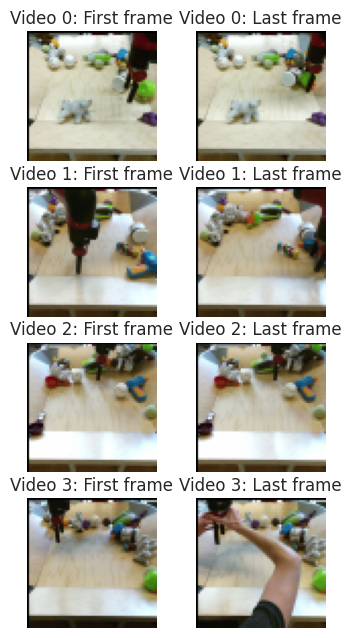

In [6]:
# @title Visualize loaded videos start and end frames.

print('Test videos shape [batch_size, start/end frame, height, width, num_channels]: ', input_frames.shape)
sns.set_style('white')
plt.figure(figsize=(4, 2*batch_size))

for i in range(batch_size)[:4]:
  plt.subplot(batch_size, 2, 1 + 2*i)
  plt.imshow(input_frames[i, 0] / 255.0)
  plt.title('Video {}: First frame'.format(i))
  plt.axis('off')
  plt.subplot(batch_size, 2, 2 + 2*i)
  plt.imshow(input_frames[i, 1] / 255.0)
  plt.title('Video {}: Last frame'.format(i))
  plt.axis('off')

### Hub 모듈 로드하기

In [7]:
hub_handle = 'https://tfhub.dev/google/tweening_conv3d_bair/1'
module = hub.load(hub_handle).signatures['default']

### 비디오 생성 및 표시하기

In [8]:
filled_frames = module(input_frames)['default'] / 255.0

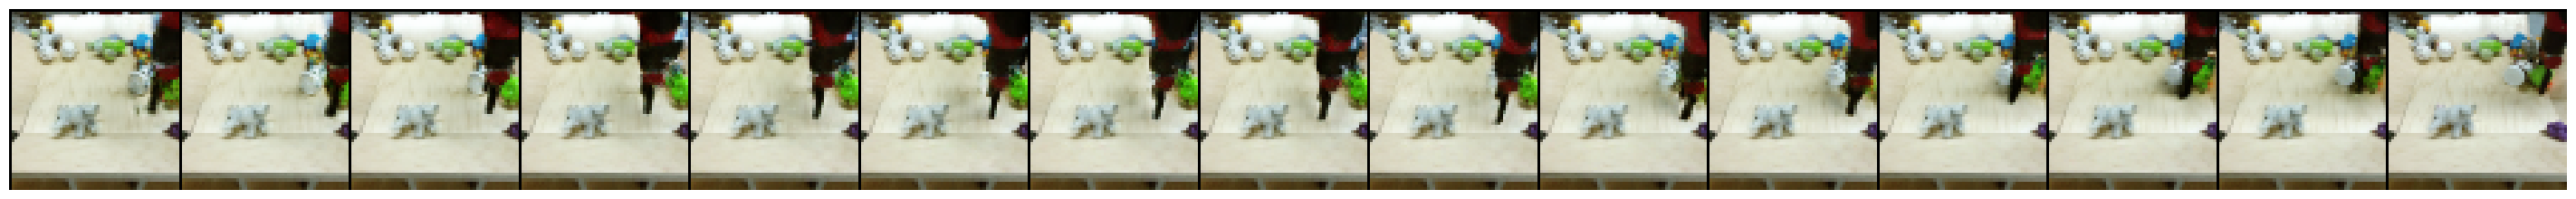

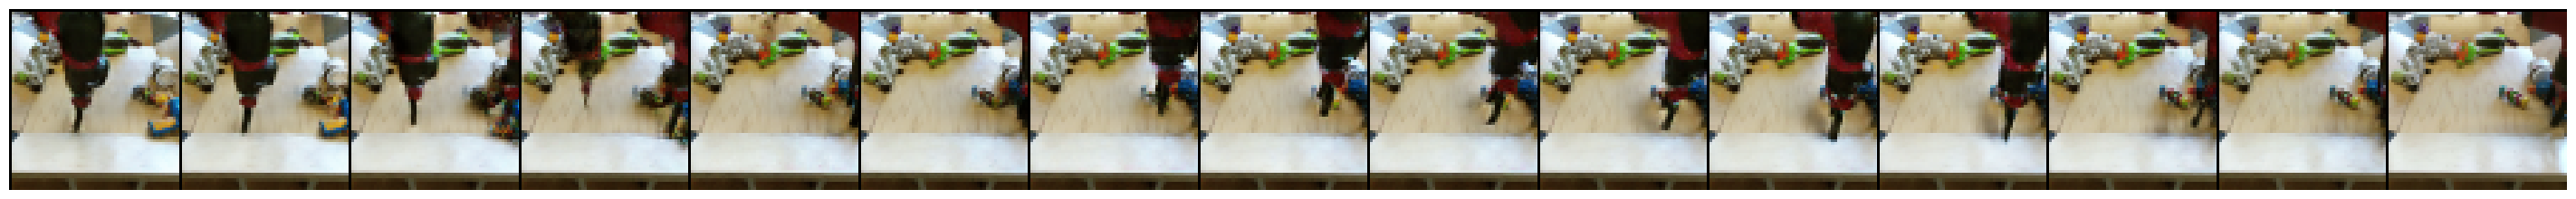

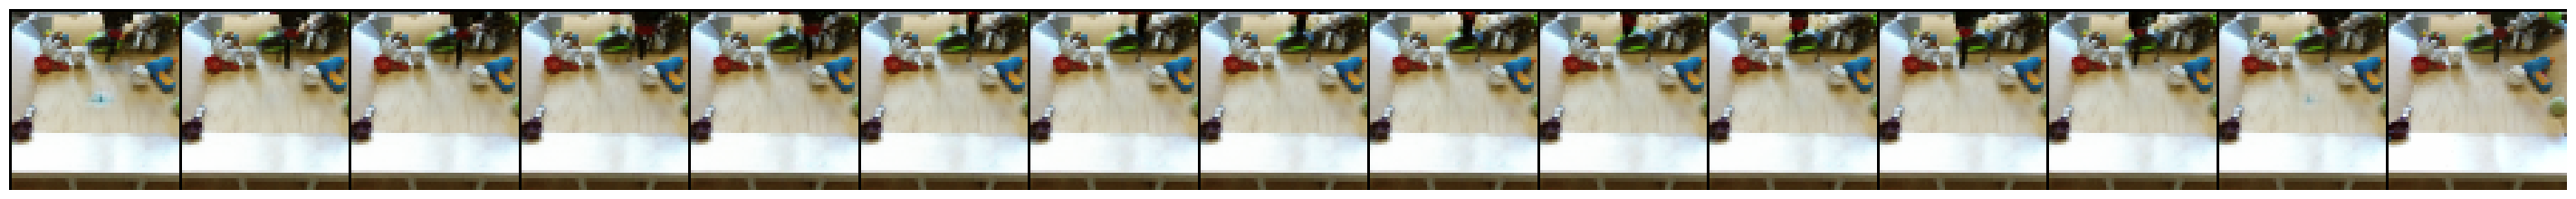

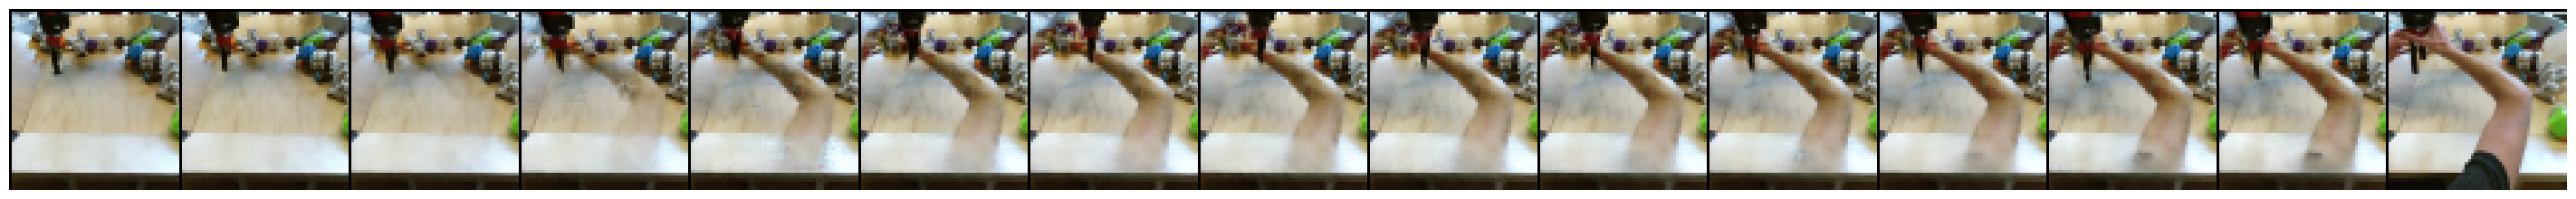

In [9]:
# Show sequences of generated video frames.

# Concatenate start/end frames and the generated filled frames for the new videos.
generated_videos = np.concatenate([input_frames[:, :1] / 255.0, filled_frames, input_frames[:, 1:] / 255.0], axis=1)

for video_id in range(4):
  fig = plt.figure(figsize=(10 * 2, 2))
  for frame_id in range(1, 16):
    ax = fig.add_axes([frame_id * 1 / 16., 0, (frame_id + 1) * 1 / 16., 1],
                      xmargin=0, ymargin=0)
    ax.imshow(generated_videos[video_id, frame_id])
    ax.axis('off')